<a href="https://colab.research.google.com/github/SatishGollamudi/NLP/blob/main/Sentiment_Analysis_with_Fine_Tuned_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets evaluate accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00


In [9]:
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    IntervalStrategy # Import IntervalStrategy
)
from datasets import load_dataset, DatasetDict
from sklearn.metrics import classification_report, confusion_matrix

print(f"GPU available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

GPU available: True
Device: Tesla T4


In [3]:
MODEL_NAME = "distilbert-base-uncased"

print("Loading IMDb dataset...")
raw = load_dataset("imdb")

# Using subset for speed — remove .select() for full training
train_data = raw["train"].shuffle(seed=42).select(range(3000))
test_data  = raw["test"].shuffle(seed=42).select(range(750))

dataset = DatasetDict({"train": train_data, "test": test_data})
print(f"Train: {len(dataset['train'])} samples")
print(f"Test:  {len(dataset['test'])} samples")
print(f"\nSample: {dataset['train'][0]}")

Loading IMDb dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train: 3000 samples
Test:  750 samples

Sample: {'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}


In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

print("Tokenizing...")
tokenized = dataset.map(tokenize_fn, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("Done! Sample keys:", tokenized["train"][0].keys())

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Done! Sample keys: dict_keys(['label', 'input_ids', 'attention_mask'])


In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

# Count trainable parameters
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters:     {total:,}")
print(f"Trainable parameters: {trainable:,}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Total parameters:     66,955,010
Trainable parameters: 66,955,010


In [6]:
accuracy_metric = evaluate.load("accuracy")
f1_metric       = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        **accuracy_metric.compute(predictions=preds, references=labels),
        **f1_metric.compute(predictions=preds, references=labels)
    }

In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=56, # Replaced warmup_ratio with warmup_steps
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    logging_strategy=IntervalStrategy.STEPS,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),   # automatic on GPU
    seed=42,
    report_to="none"
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Starting training...")
trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.349160,0.304564,0.869333,0.863889
2,0.230823,0.338411,0.868000,0.871928
3,0.146673,0.383212,0.876000,0.876494


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=564, training_loss=0.2895591804321776, metrics={'train_runtime': 83.9505, 'train_samples_per_second': 107.206, 'train_steps_per_second': 6.718, 'total_flos': 596103293952000.0, 'train_loss': 0.2895591804321776, 'epoch': 3.0})


Final Results:
  eval_loss: 0.3832
  eval_accuracy: 0.8760
  eval_f1: 0.8765
  eval_runtime: 2.3083
  eval_samples_per_second: 324.9180
  eval_steps_per_second: 10.3970
  epoch: 3.0000

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.91      0.84      0.88       388
    POSITIVE       0.84      0.91      0.88       362

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750



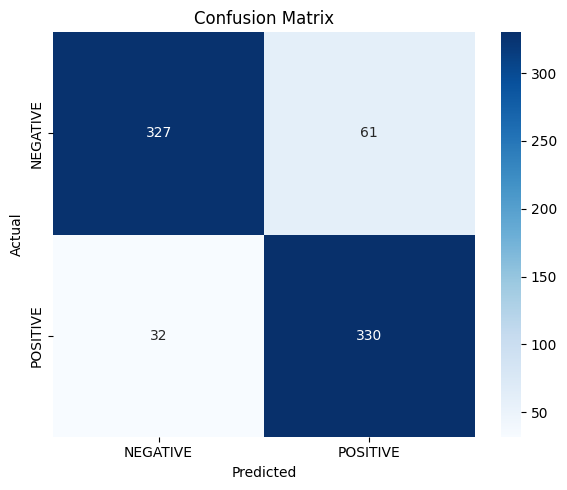

In [17]:
# Final metrics
results = trainer.evaluate()
print("\nFinal Results:")
for k, v in results.items():
    print(f"  {k}: {v:.4f}")

# Confusion Matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

all_preds, all_labels = [], []
for i in range(0, len(tokenized["test"]), 32):
    batch = tokenized["test"][i:i+32]
    with torch.no_grad():
        outputs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        )
    all_preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().tolist())
    all_labels.extend(batch["label"].tolist())

# Plot
print("\nClassification Report:")
print(classification_report(all_labels, all_preds,
      target_names=["NEGATIVE", "POSITIVE"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NEGATIVE", "POSITIVE"],
            yticklabels=["NEGATIVE", "POSITIVE"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [18]:
from google.colab import drive
drive.mount('/content/drive')

# Save
MODEL_SAVE_PATH = "/content/drive/MyDrive/sentiment_model"
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"Model saved to Google Drive: {MODEL_SAVE_PATH}")

Mounted at /content/drive


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to Google Drive: /content/drive/MyDrive/sentiment_model


In [20]:
from transformers import pipeline

# Load from Drive
MODEL_SAVE_PATH = "/content/drive/MyDrive/sentiment_model"

classifier = pipeline(
    "text-classification",
    model=MODEL_SAVE_PATH,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# Test it!
test_sentences = [
    "This movie was absolutely fantastic, I loved every minute!",
    "Terrible film. Boring, predictable and poorly acted.",
    "It was okay, not great but not terrible either.",
    "One of the best performances I've seen in years.",
    "Complete waste of time and money."
]

print("Predictions:\n")
for text in test_sentences:
    # classifier(text) returns a list of dictionaries when return_all_scores=True
    all_scores = classifier(text)
    # Create a dictionary mapping labels to their scores
    scores = {r["label"]: r["score"] for r in all_scores}
    # Find the label with the highest score
    label  = max(scores, key=scores.get)
    conf   = scores[label]
    emoji  = "😊" if label == "POSITIVE" else "😞"
    print(f"{emoji} [{label} — {conf:.1%}]\n   {text}\n")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Predictions:

😊 [POSITIVE — 98.7%]
   This movie was absolutely fantastic, I loved every minute!

😞 [NEGATIVE — 98.2%]
   Terrible film. Boring, predictable and poorly acted.

😊 [POSITIVE — 61.0%]
   It was okay, not great but not terrible either.

😊 [POSITIVE — 98.7%]
   One of the best performances I've seen in years.

😞 [NEGATIVE — 97.7%]
   Complete waste of time and money.



In [26]:
from ipywidgets import widgets
from IPython.display import display, clear_output

text_input = widgets.Textarea(
    placeholder="Type a movie review here...",
    layout=widgets.Layout(width="600px", height="100px")
)
button = widgets.Button(description="Analyze", button_style="primary")
output = widgets.Output()

def on_click(b):
    with output:
        clear_output()
        text = text_input.value.strip()
        if not text:
            print("Please enter some text!")
            return
        # classifier(text) returns a list of dictionaries when return_all_scores=True
        all_scores = classifier(text)
        # Create a dictionary mapping labels to their scores
        scores = {r["label"]: r["score"] for r in all_scores}
        # Find the label with the highest score
        label  = max(scores, key=scores.get)
        conf   = scores[label]
        emoji  = "😊" if label == "POSITIVE" else "😞"
        print(f"\nResult: {emoji} {label}")
        print(f"Confidence: {conf:.1%}")
        print(f"  POSITIVE: {scores.get('POSITIVE', 0.0):.1%}")
        print(f"  NEGATIVE: {scores.get('NEGATIVE', 0.0):.1%}")

button.on_click(on_click)
display(text_input, button, output)

Textarea(value='', layout=Layout(height='100px', width='600px'), placeholder='Type a movie review here...')

Button(button_style='primary', description='Analyze', style=ButtonStyle())

Output()